In [1]:
import matplotlib
import pandas as pd
import numpy as np
#import cbor2
import librosa
from scipy.signal import butter
from scipy.signal import lfilter
from scipy.signal import filtfilt
from scipy.signal import freqz;
import matplotlib.pyplot as plt
#import plotly.express as px
import IPython.display as ipd
import scipy.signal as signal
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller

def check_stationarity(series):
    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")
        
def compute_fft(s, sampling_rate, n = None, scale_amplitudes = True):
    '''Computes an FFT on signal s using numpy.fft.fft.
    
       Parameters:
        s (np.array): the signal
        sampling_rate (num): sampling rate
        n (integer): If n is smaller than the length of the input, the input is cropped. If n is 
            larger, the input is padded with zeros. If n is not given, the length of the input signal 
            is used (i.e., len(s))
        scale_amplitudes (boolean): If true, the spectrum amplitudes are scaled by 2/len(s)
    '''
    if n == None:
        n = len(s)
        
    fft_result = np.fft.fft(s, n)
    num_freq_bins = len(fft_result)
    fft_freqs = np.fft.fftfreq(num_freq_bins, d = 1 / sampling_rate)
    half_freq_bins = num_freq_bins // 2

    fft_freqs = fft_freqs[:half_freq_bins]
    fft_result = fft_result[:half_freq_bins]
    fft_amplitudes = np.abs(fft_result)
    
    if scale_amplitudes is True:
        fft_amplitudes = 2 * fft_amplitudes / (len(s))
    
    return (fft_freqs, fft_amplitudes);


def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='lowpass', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    
    
    
    #y = lfilter(b, a, data)
    y = filtfilt(b, a, data)
    return y;

def cbor2csv(filename):
    '''
    Function to convert cbro files to csv.
    Depends on: Numpy, Pandas and Cbor2 library
    Input: Filename with cbor
    Output: Stores the same name csv file
    '''
    with open(filename, 'rb') as fp:
        obj = cbor2.load(fp)  
        pd.DataFrame(data=np.array(obj['payload']['values']),columns=['X','Y','Z']).to_csv(filename.split('.')[0]+".csv", index=False)



In [2]:
import seaborn as sns

## TVOC and eCO2 Sensor Inside The Mask | 12.02.2022 | N95 Mask | 1
**2 Minutes of Idle, 2 Minutes Of Loose Mask, Next 2 Minutes of Tight Mask**<br>
**Mask tightness reported at 4.11 second**

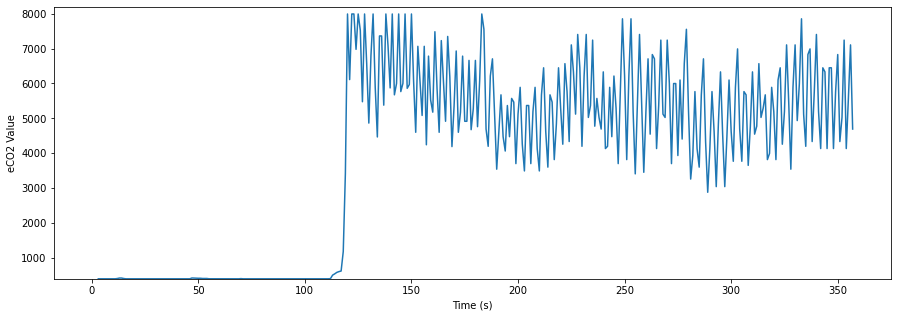

In [5]:
eco2 = pd.read_csv('data/DATALOG_12022022_1.csv', names=['eCO2','TVOC'])
ax1 = eco2['eCO2'].plot(figsize=(15,5), subplots=True,ylim=(400,8192),xlabel='Time (s)',ylabel='eCO2 Value')
#ax1 = eco2['TVOC'].plot(figsize=(15,5), subplots=True,ylim=(0,1187),xlabel='Time (s)',ylabel='eCO2 Value')
#ax1[0].axvline(250,color='r')

#ax1[0].axvline(320,color='r') #marker for end of mask off period
#ax1[0].text(200, 2500, 'Mask Off', fontsize='x-large', c='black')

#ax1[0].text(400, 2500, '40 BPM Metronome', fontsize='x-large')
#ax1[0].text(400, 2000, 'RR=20 (Good)', fontsize='x-large', c='green')

In [11]:
#ACF using Numpy for mask tight
start = 120
end = 180
acf = np.correlate(np.array(eco2[start:end]['eCO2']), np.array(eco2[start:end]['eCO2']), 'full')[-len(np.array(eco2[start:end]['eCO2'])):]
inflection = np.diff(np.sign(np.diff(acf))) # Find the second-order differences
peaks = (inflection < 0).nonzero()[0] + 1 # Find where they are negative
delay = peaks[acf[peaks].argmax()] # Of those, find the index with the maximum value
signal_freq = 1/delay #
print(signal_freq*60)

20.0


In [13]:
#std across 20 minutes interval
for i in range(0,180,20):
    #print("Start Time is = {} and End Time is = {}".format(i,i+20))
    print(np.std(eco2[i:i+20]['eCO2']))
#

144.18769018192913
0.0
7.999374975584029
1.2409673645990857
0.0
663.4959984807746
1126.5082955753146
1083.9168971835434
1017.1594811041186


In [7]:
#ACF using Numpy for mask tight
start = 240+11
end = len(eco2)
acf = np.correlate(np.array(eco2[start:end]['eCO2']), np.array(eco2[start:end]['eCO2']), 'full')[-len(np.array(eco2[start:end]['eCO2'])):]
inflection = np.diff(np.sign(np.diff(acf))) # Find the second-order differences
peaks = (inflection < 0).nonzero()[0] + 1 # Find where they are negative
delay = peaks[acf[peaks].argmax()] # Of those, find the index with the maximum value
signal_freq = 1/delay #
print(signal_freq*60)

20.0


## TVOC and eCO2 Sensor Inside The Mask | 12.02.2022 | N95 Mask | 2
**Breathe Hold For 30 Seconds, About 13-14 Breathe Post that**<br>


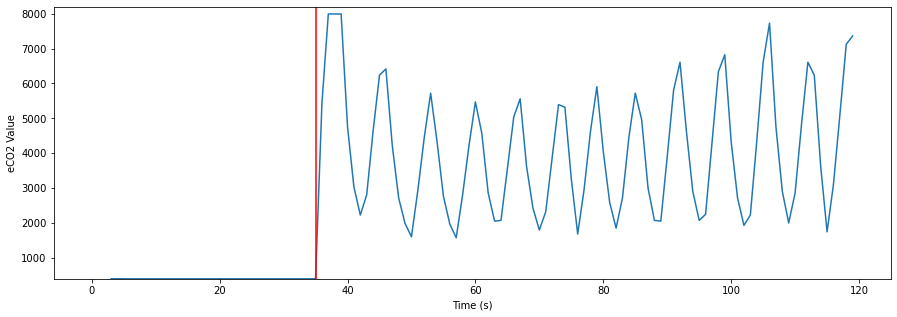

In [18]:
eco2 = pd.read_csv('data/DATALOG_12022022_2.csv', names=['eCO2','TVOC'])
ax1 = eco2['eCO2'].plot(figsize=(15,5), subplots=True,ylim=(400,8192),xlabel='Time (s)',ylabel='eCO2 Value')
#ax1 = eco2['TVOC'].plot(figsize=(15,5), subplots=True,ylim=(0,1187),xlabel='Time (s)',ylabel='eCO2 Value')
ax1[0].axvline(35,color='r')

#ax1[0].axvline(320,color='r') #marker for end of mask off period
#ax1[0].text(200, 2500, 'Mask Off', fontsize='x-large', c='black')

#ax1[0].text(400, 2500, '40 BPM Metronome', fontsize='x-large')
#ax1[0].text(400, 2000, 'RR=20 (Good)', fontsize='x-large', c='green')

In [23]:
#ACF using Numpy for mask tight
start = 45
end = len(eco2)
acf = np.correlate(np.array(eco2[start:end]['eCO2']), np.array(eco2[start:end]['eCO2']), 'full')[-len(np.array(eco2[start:end]['eCO2'])):]
inflection = np.diff(np.sign(np.diff(acf))) # Find the second-order differences
peaks = (inflection < 0).nonzero()[0] + 1 # Find where they are negative
delay = peaks[acf[peaks].argmax()] # Of those, find the index with the maximum value
signal_freq = 1/delay #
print(signal_freq*60)

10.0


In [26]:
#RR calculation every minute
for i in range(0,len(eco2),60):
    start = i;
    end = start+60
    acf = np.correlate(np.array(eco2[start:end]['eCO2']), np.array(eco2[start:end]['eCO2']), 'full')[-len(np.array(eco2[start:end]['eCO2'])):]
    inflection = np.diff(np.sign(np.diff(acf))) # Find the second-order differences
    peaks = (inflection < 0).nonzero()[0] + 1 # Find where they are negative
    delay = peaks[acf[peaks].argmax()] # Of those, find the index with the maximum value
    signal_freq = 1/delay #
    print(signal_freq*60)

8.571428571428571
10.0


## TVOC and eCO2 Sensor Inside The Mask | 12.02.2022 | N95 Mask | 3
**1 min: 16**<br>
**2 min: 15**<br>
**3 min: 19**<br>
**4 min: 14**(forget)<br>
**6.17: Cough**<br>
**6.40: Talking started**<br>
**17:23: Talking**


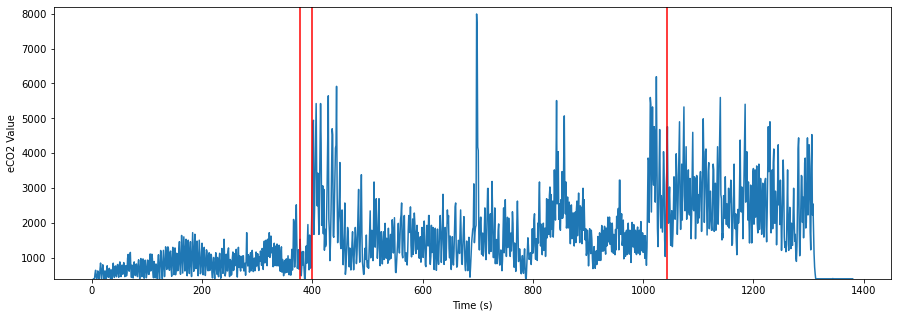

In [58]:
eco2 = pd.read_csv('data/DATALOG_12022022_3.csv', names=['eCO2','TVOC'])
ax1 = eco2['eCO2'].plot(figsize=(15,5), subplots=True,ylim=(400,8192),xlabel='Time (s)',ylabel='eCO2 Value')
#ax1 = eco2['TVOC'].plot(figsize=(15,5), subplots=True,ylim=(0,1187),xlabel='Time (s)',ylabel='eCO2 Value')
ax1[0].axvline(377,color='r')
ax1[0].axvline(400,color='r')
ax1[0].axvline(1043,color='r')

#ax1[0].axvline(320,color='r') #marker for end of mask off period
#ax1[0].text(200, 2500, 'Mask Off', fontsize='x-large', c='black')

#ax1[0].text(400, 2500, '40 BPM Metronome', fontsize='x-large')
#ax1[0].text(400, 2000, 'RR=20 (Good)', fontsize='x-large', c='green')

Getting RR between 0 secoonds and 60 seconds
Reported RR is = 15.0

Getting RR between 60 secoonds and 120 seconds
Reported RR is = 15.0

Getting RR between 120 secoonds and 180 seconds
Reported RR is = 15.0

Getting RR between 180 secoonds and 240 seconds
Reported RR is = 15.0

Getting RR between 240 secoonds and 300 seconds
Reported RR is = 20.0

Getting RR between 300 secoonds and 360 seconds
Reported RR is = 20.0

Getting RR between 360 secoonds and 420 seconds
Reported RR is = 2.608695652173913

Getting RR between 420 secoonds and 480 seconds
Reported RR is = 8.571428571428571

Getting RR between 480 secoonds and 540 seconds
Reported RR is = 15.0

Getting RR between 540 secoonds and 600 seconds
Reported RR is = 15.0

Getting RR between 600 secoonds and 660 seconds
Reported RR is = 15.0

Getting RR between 660 secoonds and 720 seconds
Reported RR is = 12.0

Getting RR between 720 secoonds and 780 seconds
Reported RR is = 20.0

Getting RR between 780 secoonds and 840 seconds
Reporte

D:\anaconda3\lib\site-packages\statsmodels\graphics\utils.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


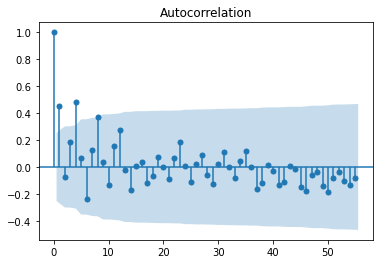

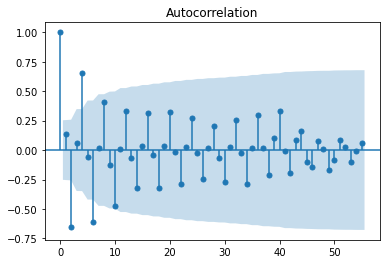

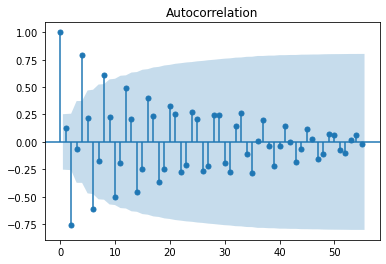

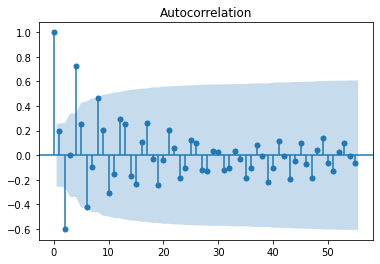

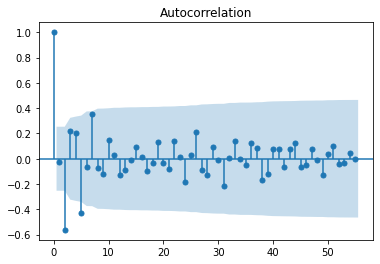

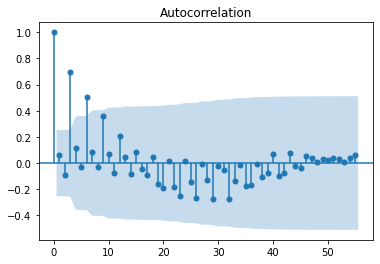

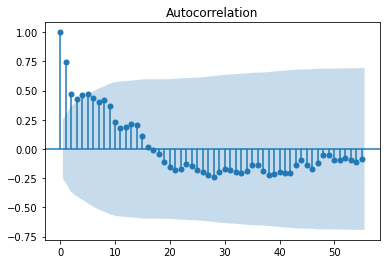

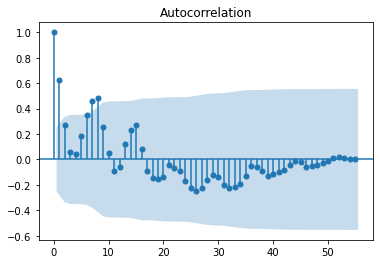

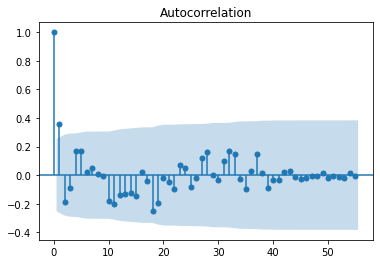

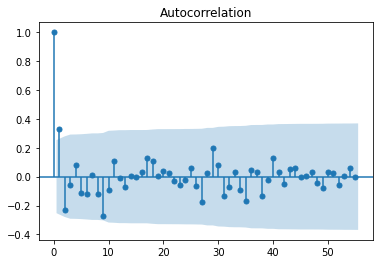

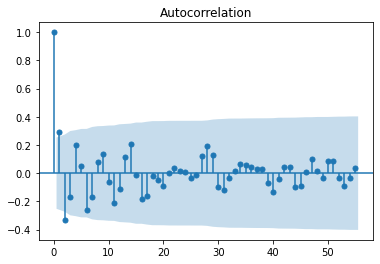

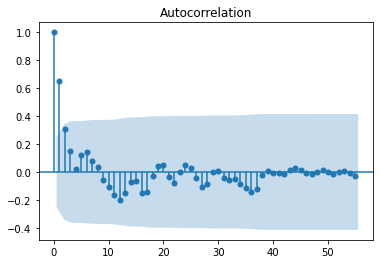

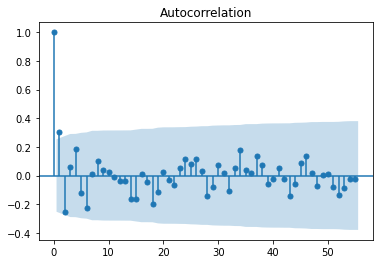

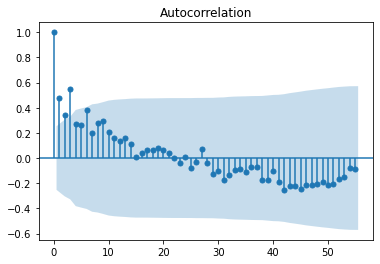

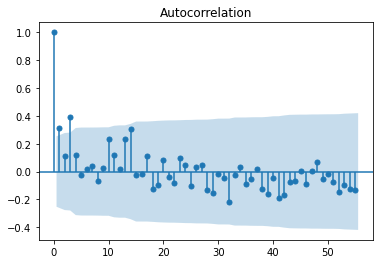

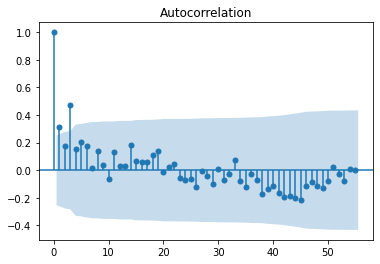

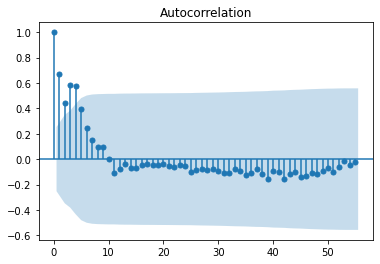

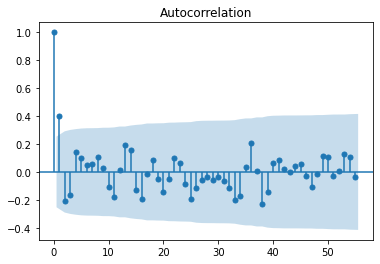

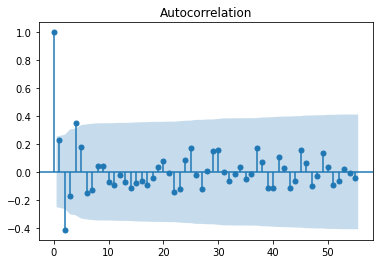

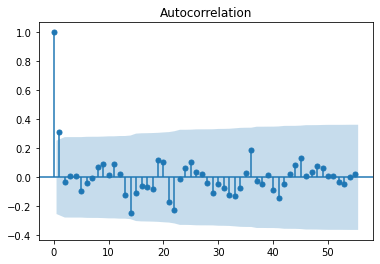

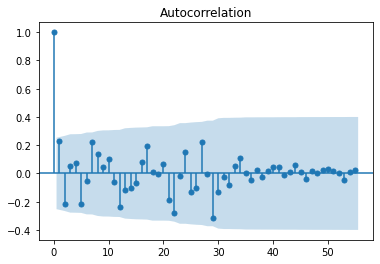

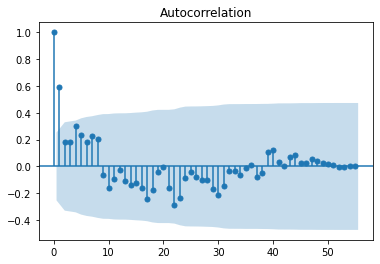

In [74]:
#RR calculation every minute
for i in range(0,len(eco2),60):
    try:
        start = i;
        end = start+60
        print("Getting RR between {} secoonds and {} seconds".format(start, end))
        acf = np.correlate(np.array(eco2[start:end]['eCO2']), np.array(eco2[start:end]['eCO2']), 'full')[-len(np.array(eco2[start:end]['eCO2'])):]
        inflection = np.diff(np.sign(np.diff(acf))) # Find the second-order differences
        peaks = (inflection < 0).nonzero()[0] + 1 # Find where they are negative
        delay = peaks[acf[peaks].argmax()] # Of those, find the index with the maximum value
        signal_freq = 1/delay #
        print("Reported RR is = {}\n".format(signal_freq*60))
        plot_acf(eco2[start:end]['eCO2'], lags=55)
    except:
        print("Could not find for {} secoonds and {} seconds".format(start, end))

# Random

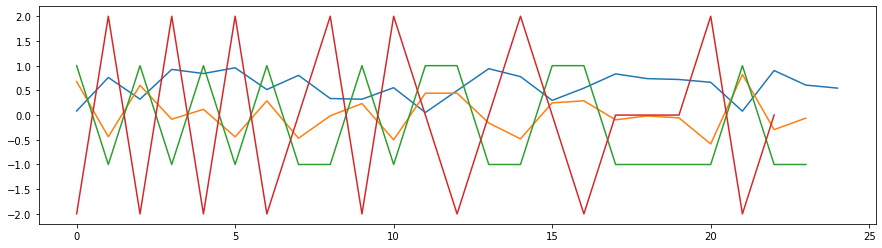

In [47]:
dummy = np.random.rand(25)
fig, ax = plt.subplots(1,1,figsize=(15,4))
ax.plot(dummy)
diff = np.diff(dummy)
ax.plot(diff)
sign = np.sign(diff)
ax.plot(sign)
diff_of_sign = np.diff(sign)
ax.plot(diff_of_sign)

## TVOC and eCO2 Sensor Inside The Mask | 15.02.2022 | N95 Mask | 1
**20 Minutes Idle = 1200**--<br>
**Long breathe at around 22 minute = 1320**<br>
**At 26 minute Yawn = 1560**<br>
**At 37 burp 2 times = 2220**<br>
**At 43 yawns, 43.41burp = 2621**<br>
**At 45 long breathe = 2700**<br>
**At 51 burp and breathe = 3060**<br>
**At 55 blow air = 3300**<br>
**At 58 talking = 3480**<br>
**At 60 Burp = 3600**

**Mask Loosened**<br>
**At 71 minute, mask opened = 4260**<br>

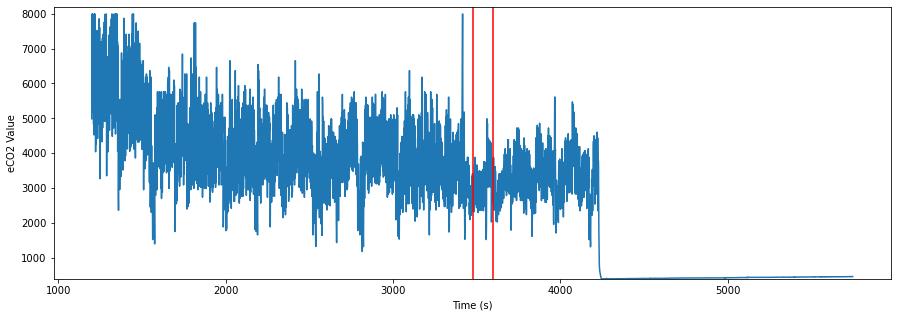

In [20]:
eco2 = pd.read_csv('data/DATALOG_15022022_1.csv', names=['eCO2','TVOC'])
ax1 = eco2['eCO2'][1200:].plot(figsize=(15,5), subplots=True,ylim=(400,8192),xlabel='Time (s)',ylabel='eCO2 Value')
#ax1 = eco2['TVOC'].plot(figsize=(15,5), subplots=True,ylim=(0,1187),xlabel='Time (s)',ylabel='eCO2 Value')
ax1[0].axvline(3480,color='r')
ax1[0].axvline(3600,color='r')
#ax1[0].axvline(400,color='r')
#ax1[0].axvline(1043,color='r')

#ax1[0].axvline(320,color='r') #marker for end of mask off period
#ax1[0].text(200, 2500, 'Mask Off', fontsize='x-large', c='black')

#ax1[0].text(400, 2500, '40 BPM Metronome', fontsize='x-large')
#ax1[0].text(400, 2000, 'RR=20 (Good)', fontsize='x-large', c='green')

Getting RR between 0 secoonds and 60 seconds
Could not find for 0 secoonds and 60 seconds

Getting RR between 60 secoonds and 120 seconds
Could not find for 60 secoonds and 120 seconds

Getting RR between 120 secoonds and 180 seconds
Could not find for 120 secoonds and 180 seconds

Getting RR between 180 secoonds and 240 seconds
Could not find for 180 secoonds and 240 seconds

Getting RR between 240 secoonds and 300 seconds
Could not find for 240 secoonds and 300 seconds

Getting RR between 300 secoonds and 360 seconds
Could not find for 300 secoonds and 360 seconds

Getting RR between 360 secoonds and 420 seconds
Could not find for 360 secoonds and 420 seconds

Getting RR between 420 secoonds and 480 seconds
Could not find for 420 secoonds and 480 seconds

Getting RR between 480 secoonds and 540 seconds
Could not find for 480 secoonds and 540 seconds

Getting RR between 540 secoonds and 600 seconds
Could not find for 540 secoonds and 600 seconds

Getting RR between 600 secoonds and 66

D:\anaconda3\lib\site-packages\statsmodels\graphics\utils.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


Getting RR between 2640 secoonds and 2700 seconds
Reported RR is = 20.0

Getting RR between 2700 secoonds and 2760 seconds
Reported RR is = 20.0

Getting RR between 2760 secoonds and 2820 seconds
Reported RR is = 20.0

Getting RR between 2820 secoonds and 2880 seconds
Reported RR is = 20.0

Getting RR between 2880 secoonds and 2940 seconds
Reported RR is = 20.0

Getting RR between 2940 secoonds and 3000 seconds
Reported RR is = 20.0

Getting RR between 3000 secoonds and 3060 seconds
Reported RR is = 3.333333333333333

Getting RR between 3060 secoonds and 3120 seconds
Reported RR is = 20.0

Getting RR between 3120 secoonds and 3180 seconds
Reported RR is = 15.0

Getting RR between 3180 secoonds and 3240 seconds
Could not find for 3180 secoonds and 3240 seconds

Getting RR between 3240 secoonds and 3300 seconds
Reported RR is = 20.0

Getting RR between 3300 secoonds and 3360 seconds
Reported RR is = 20.0

Getting RR between 3360 secoonds and 3420 seconds
Could not find for 3360 secoonds 

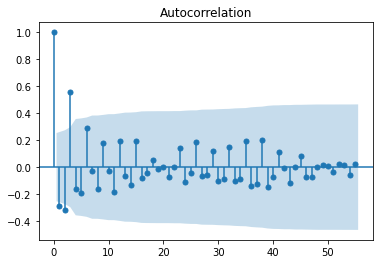

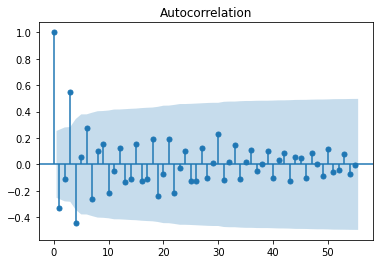

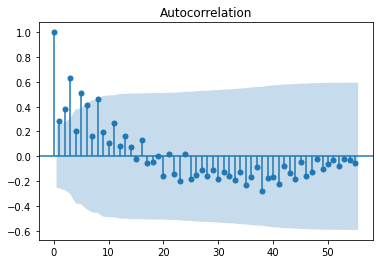

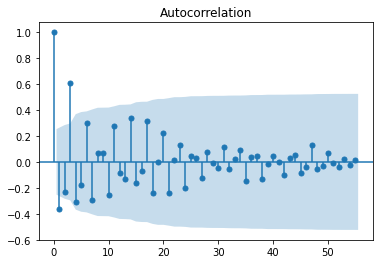

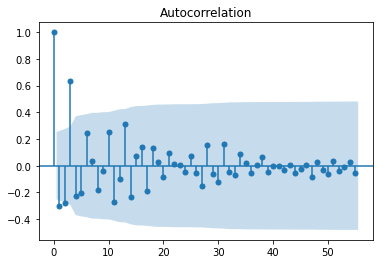

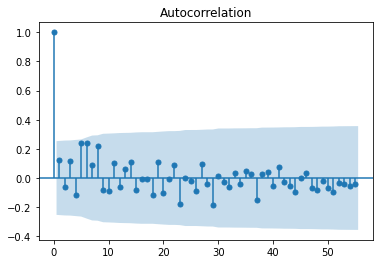

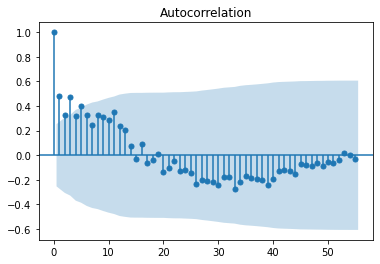

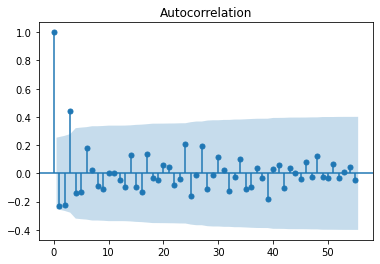

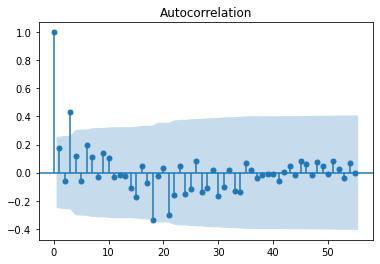

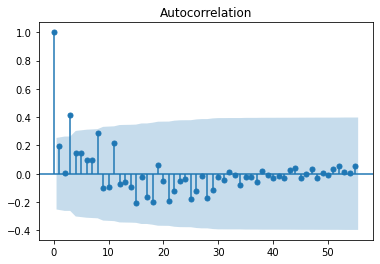

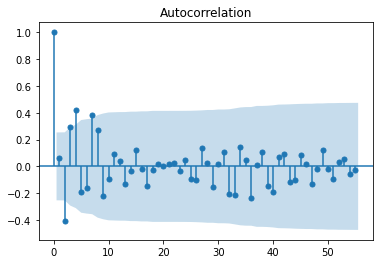

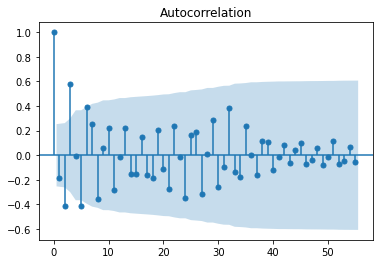

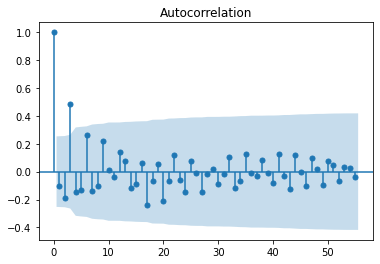

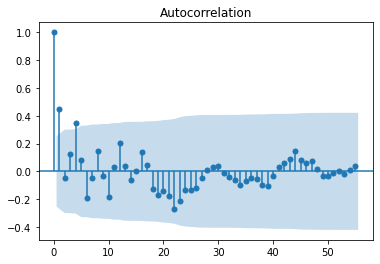

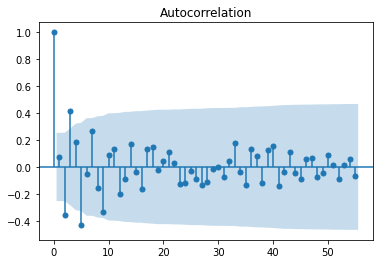

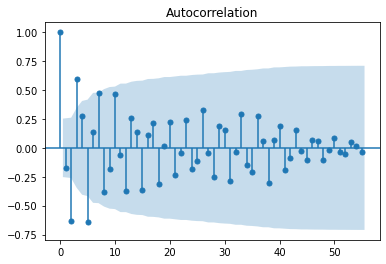

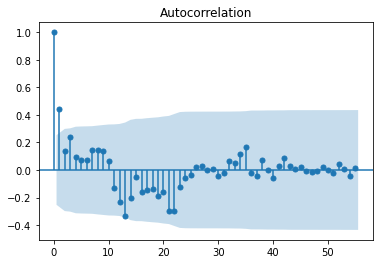

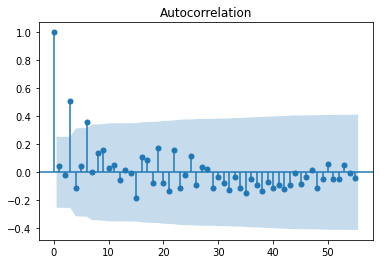

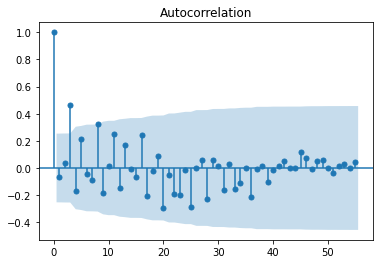

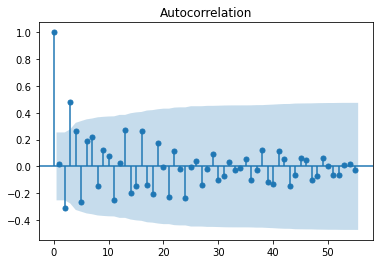

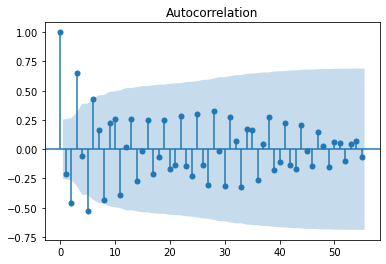

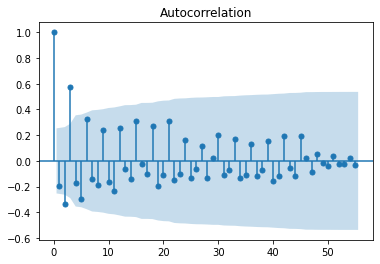

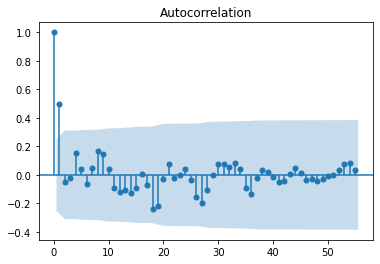

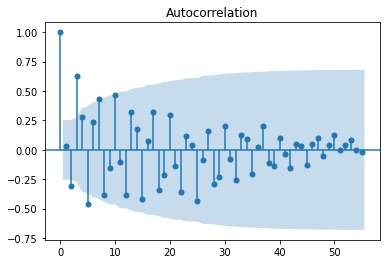

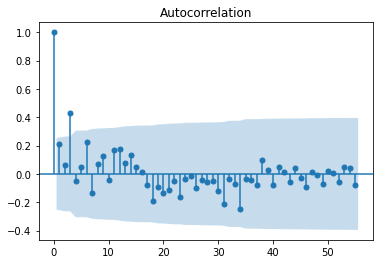

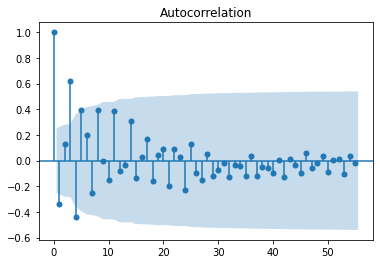

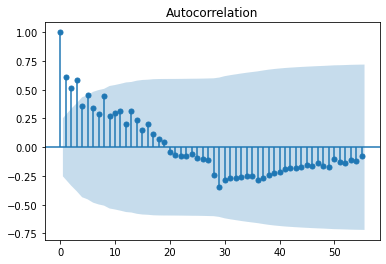

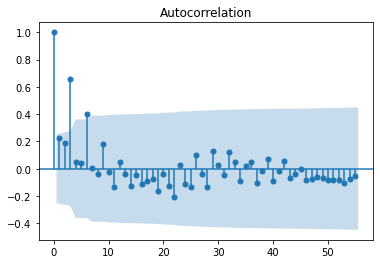

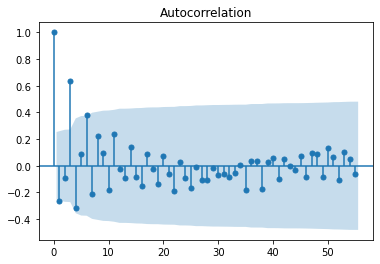

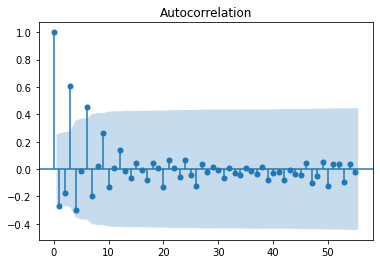

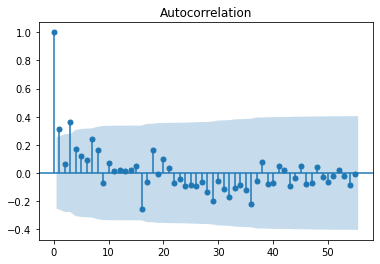

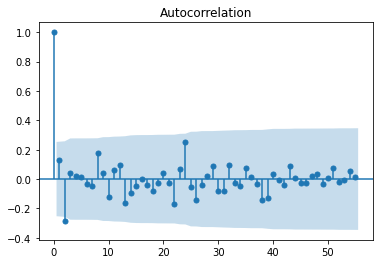

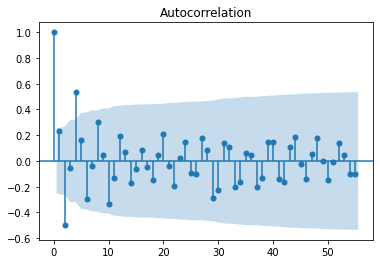

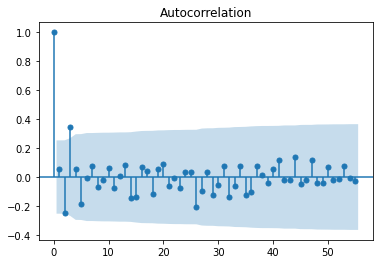

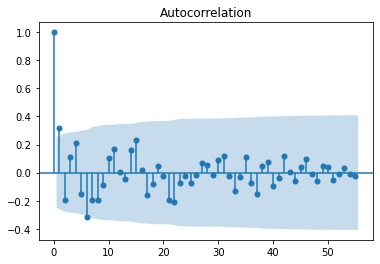

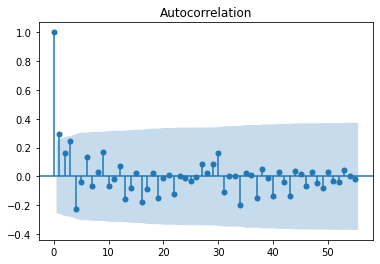

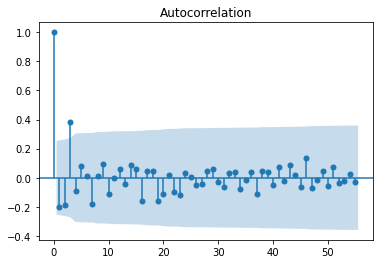

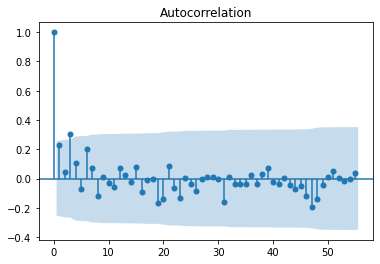

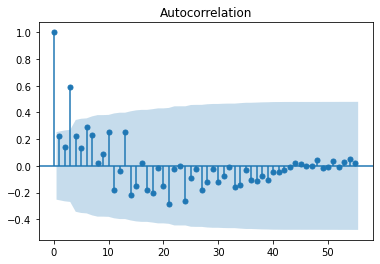

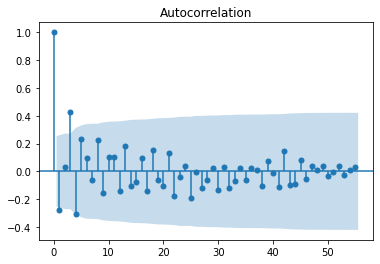

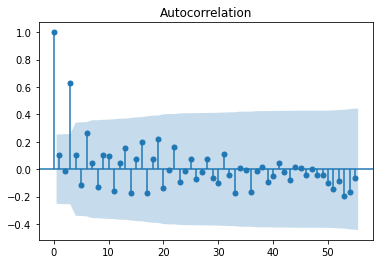

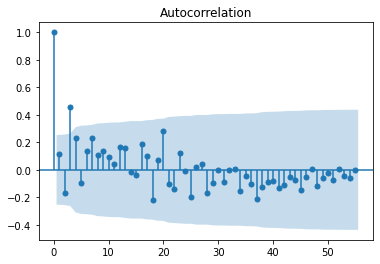

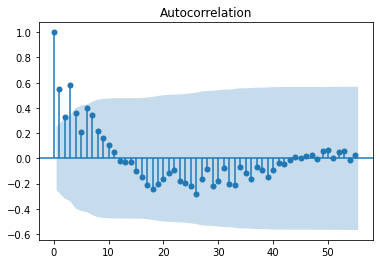

In [158]:
#RR calculation every minute
_list = []
for i in range(0,len(eco2),60):
    try:
        start = i;
        end = start+60
        print("Getting RR between {} secoonds and {} seconds".format(start, end))
        #print("Standard Deviation is = {}".format(np.std(np.array(eco2[start:end]['eCO2']))))
        _list.append(np.diff(np.array(eco2[start:end]['eCO2'])))
        acf = np.correlate(np.array(eco2[start:end]['eCO2']), np.array(eco2[start:end]['eCO2']), 'full')[-len(np.array(eco2[start:end]['eCO2'])):]
        inflection = np.diff(np.sign(np.diff(acf))) # Find the second-order differences
        peaks = (inflection < 0).nonzero()[0] + 1 # Find where they are negative
        delay = peaks[acf[peaks].argmax()] # Of those, find the index with the maximum value
        signal_freq = 1/delay #
        print("Reported RR is = {}\n".format(signal_freq*60))
        plot_acf(eco2[start:end]['eCO2'], lags=55)
    except:
        print("Could not find for {} secoonds and {} seconds\n".format(start, end))

In [146]:
len(eco2[1200:1400]['eCO2'])

200

In [167]:
'''
#sns
minute_data = np.array(list()).reshape(1,len(list()))
#fig, ax = plt.subplots(1,1,figsize=(10,4))
for i in range(0,len(eco2),60):
    try:
        start = i;
        end = start+60
        minute_data = np.concatenate((minute_data, np.array(eco2[start:end]['eCO2']).reshape(len(eco2[start:end]['eCO2']),1)), axis=0)
        #minute_data.append()
        #sns.boxplot(data=np.array(eco2[start:end]['eCO2']), ax=ax)
        
    except:
        print("Error")
'''

'\n#sns\nminute_data = np.array(list()).reshape(1,len(list()))\n#fig, ax = plt.subplots(1,1,figsize=(10,4))\nfor i in range(0,len(eco2),60):\n    try:\n        start = i;\n        end = start+60\n        minute_data = np.concatenate((minute_data, np.array(eco2[start:end][\'eCO2\']).reshape(len(eco2[start:end][\'eCO2\']),1)), axis=0)\n        #minute_data.append()\n        #sns.boxplot(data=np.array(eco2[start:end][\'eCO2\']), ax=ax)\n        \n    except:\n        print("Error")\n'

In [159]:
t1 = []
t2 = np.random.rand(12)

In [166]:
np.concatenate((t1,t2), axis=0)

array([0.10278126, 0.51273556, 0.50797732, 0.26424489, 0.98599753,
       0.39681346, 0.49584739, 0.18329536, 0.21852832, 0.81945045,
       0.23835373, 0.86621283])

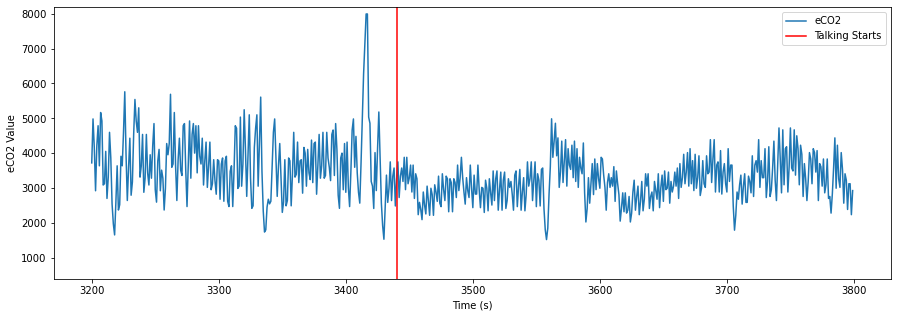

In [69]:
#Demo of difference between mask loose and mask tight
ax1 = eco2['eCO2'][3200:3800].plot(figsize=(15,5), subplots=True,ylim=(400,8192),xlabel='Time (s)',ylabel='eCO2 Value')
ax1[0].axvline(3440,color='r', label='Talking Starts')
ax1[0].legend()

## TVOC and eCO2 Sensor Inside The Mask | 28.02.2022 | N95 Mask | FVC Attempt 1
**Worn at 26th Minute**<br>


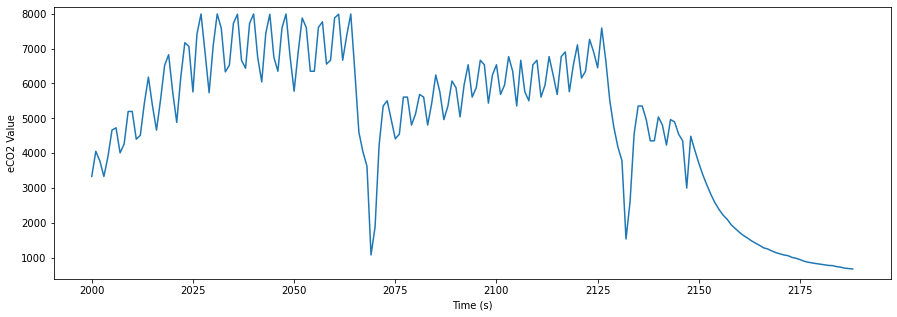

In [9]:
eco2 = pd.read_csv('data/DATALOG_28022022_1.csv', names=['eCO2','TVOC'])
ax1 = eco2['eCO2'][2000:].plot(figsize=(15,5), subplots=True,ylim=(400,8192),xlabel='Time (s)',ylabel='eCO2 Value')
#ax1 = eco2['TVOC'].plot(figsize=(15,5), subplots=True,ylim=(0,1187),xlabel='Time (s)',ylabel='eCO2 Value')


## TVOC and eCO2 Sensor Inside The Mask | 28.02.2022 | N95 Mask | FVC Attempt 2
**Worn at 26th Minute**<br>


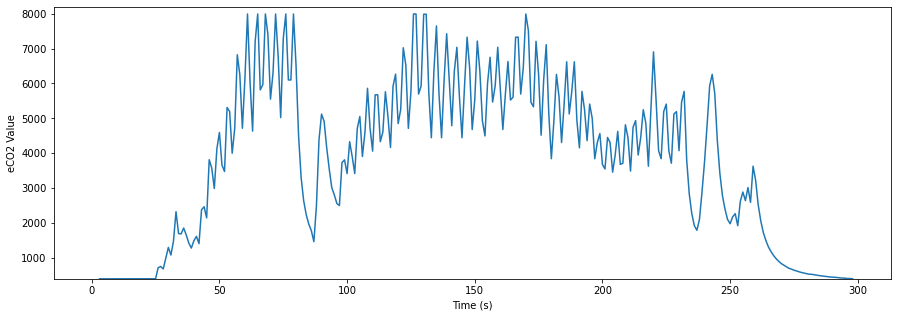

In [13]:
eco2 = pd.read_csv('data/DATALOG_28022022_2.csv', names=['eCO2','TVOC'])
ax1 = eco2['eCO2'].plot(figsize=(15,5), subplots=True,ylim=(400,8192),xlabel='Time (s)',ylabel='eCO2 Value')
#ax1 = eco2['TVOC'].plot(figsize=(15,5), subplots=True,ylim=(0,1187),xlabel='Time (s)',ylabel='eCO2 Value')


In [14]:
#todo..increase write speed